## Project 5 : Optimizing Evacuation Routes using Real-Time Traffic Information

**By: Amy Ontiveros-Bear, Ruchika Sah & Benjamin Haile**

### Problem Statement:

 In this project we were tasked with optimizing the best evacuation route from Central Park to Prospect Park.The ideal output should map the fastest route given live and historical traffic data. Since Tom Tom API essentially does this already we wanted to validate it’s efficiency. We will test our theory by utilizing DBSCAN to cluster historically dense traffic regions. Then compare the live routing mechanism of Tom Tom to our cluster output. The pseudo metric used will be silhouette score.

## Executive Summary


**EDA & Outside Research:**

Our analysis shows that data collected from the TomTom API offers a fuller sense of traffic and road incidents. Although the NYC Open Data dataset is comprehensive, we see that the TomTom data can better say which types of incidents are more common and offers different insights into when incidents happen. The TomTom data is clearly valuable for predicting evacuation routes, because it demonstrates that measuring collisions alone is not enough to understand many possible events that can cause traffic. This data confirms certain observations on when incidents are most likely to happen, but also raises new questions about why certain events may happen when they do, as seen in the heatmaps in the EDA notebook.


**Modeling:**

We pulled data multiple times a day from the Tom Tom API to be able to get live data about road and traffic conditions in the city. After cleaning and doing basic EDA, in order to validate the efficiency of routing given by Tom Tom we decided to use an Unsupervised Model since we did not have a target variable. We used the DBSCAN Clustering Algorithm to cluster high density traffic areas in the city. Due to the fact that it is an UNSUPERVISED clustering algorithm there is no true way to evaluate it. The mechanism for clustering is that the neighborhood of a given radius has to contain  a minimum number of points.  Therefore the parameters of the model are the radius  and the number of points included in the cluster. For our modeling we utilized the coordinates of traffic incidents. We tried different values for the eps and minimum number of observations to get the best value counts for the clusters and minimizing the outliers. We also tried to get the best value for the Silhouette Score 
Being that there is no way to really evaluate the model, we still used pseudo metrics for our evaluation purposes.
The Silhouette Score shows the proximity and density of clusters and has values from -1 to 1. We chose this one because it is a better measurement for the relationship between our clusters.

**Mapping:**


Our job is to optimize and map the best evacuation route from Central Park to Prospect Park. Tom Tom API does this for us already, it is a multilingual, globally supported, reliable and free source for live traffic and routing data. Being that our client will need our project to be implemented on a global scale at some point, Tom Tom is ideal choice. We prove this by comparing its live routing mechanism overlaid on historical New York traffic clusters to validated its  efficiency by always routing around these clusters.

## Loading Libraries and Data:

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time
import requests
import folium
import leaflet
import warnings 
warnings.filterwarnings("ignore") 
import statsmodels.api as sm
%matplotlib inline


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

In [27]:
df_historic_traffic = pd.read_csv('./data/df_db.csv')

- Grabbing data from Tom Tom API via Routing.

In [3]:
ENV = pd.read_json("env.json", typ = "series")
API_KEY = ENV["API KEY"]

In [4]:
url2 = "https://api.tomtom.com/routing/1/calculateRoute/40.785091%2C-73.968285%3A40.665535%2C-73.969749/json?computeBestOrder=true&routeRepresentation=polyline&computeTravelTimeFor=all&routeType=fastest&traffic=true&avoid=unpavedRoads&key=" + API_KEY

In [5]:
res2 = requests.get(url2)

- Ensuring my request is valid with 200 status.

In [6]:
res2.status_code

200

In [7]:
json_data = res2.json()

### Parsing JSON Data:
- I had to parse down to just the latitude and longitude in order to map my routing polyline.

In [8]:
df_routing_1 = json_data['routes'][0]['legs'][0]['points']

In [9]:
df_routing_1 = pd.DataFrame(df_routing_1)

## Data Cleaning

Setting the variable 'description' as numbers to reflect the severity of the traffic condition. There are 11 broad categories, which included one lane closed, two lanes closed, left lane closed, right lane closed, slow traffic, maintenance work, accident, queuing traffic, stationary traffic, roadworks, construction work, major event.

In [10]:
df_historic_traffic.dropna(inplace=True)

In [11]:
df_historic_traffic['description'].unique()

array([ 4,  2,  5,  1,  3,  9, 12,  6,  8, 13, 10,  7, 14, 15, 11])

In [12]:
df_historic_traffic['description'] = df_historic_traffic['description'].map({'roadworks':4, 'slow traffic':2, 'closed':5, 'one lane closed':1,
       'queuing traffic':3, 'stationary traffic':9, 'major roadworks':12,
       'right lane closed':6, 'lane closed':8, 'construction work':13,
       'maintenance work':10, 'left lane closed':7, 'accident':14, 'major event':15,
       'two lanes closed':11, })

- Since we are only clustering according to the traffic incident's latitude and longitude, only those columns will be kept.

In [13]:
df_db = df_historic_traffic[['latitude', 'longitude']]

## DBscan Modeling:
We tried different values for the eps and minimum samples to get the best value counts for the clusters and minimizing the outliers. We also tried to get the best value for the Silhouette Score as well.

- Scaling the historic data for modeling.

In [14]:
ss = StandardScaler()
X_scaled_live = ss.fit_transform(df_db)

- Fitting and using the model:

In [15]:
dbscan = DBSCAN(eps = 0.36, min_samples=9)
dbscan.fit(X_scaled_live)

DBSCAN(algorithm='auto', eps=0.36, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=9, n_jobs=None, p=None)

In [16]:
set(dbscan.labels_)

{-1, 0, 1, 2, 3, 4}

## Model Evaluation:

Even though there is no true way to evaluate the model, we still used pseudo metrics for our evaluation purposes.


- **Inertia** - is the sum of squared error for each cluster and assumes the clusters are convex. Therefore the smaller the inertia the denser the cluster.

- **Silhouette Score** -  is  gauged from -1 to 1. It is calculated utilizing the mean intra-cluster distance between point and the mean nearest-cluster distance. We chose this one because it is a better measurement for the relationship between our clusters.

- **Since the model is being used as visual aid a silhouette score of .34 will suffice.**

In [17]:
silhouette_score(X_scaled_live, dbscan.labels_)

0.33994053503904376

## Visualizing Clusters:

- Cluster 0 is the majority, so that is probably the orange which I am guessing that is Manhattan.
- Cluster 3 looks like Brooklyn.
- Cluster 2 looks like Jersey City.

In [18]:
df_db['cluster'] = dbscan.labels_

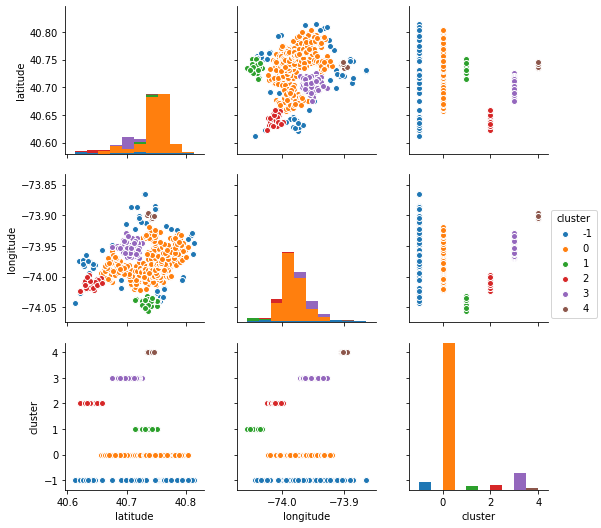

In [19]:
sns.pairplot(df_db, hue='cluster');

In [20]:
df_db['cluster'].value_counts(normalize = True)

 0    0.812350
 3    0.093023
-1    0.043304
 2    0.024058
 1    0.020048
 4    0.007217
Name: cluster, dtype: float64

## Mapping Clusters and Live Routing:

- Creating a dictionary to assign colors to the clusters:

In [21]:
color_dict = {
    -1: 'black',
    0.0 :'crimson',
    1.0:'darkcyan',
    2.0:'darkorange',
    3.0:'pink',
    4.0: 'mediumslateblue'
}

### Folium Mapping:

- Defining coordinates of where we want to center our map

In [22]:
Manhattan_coords = [40.7831, -73.9712]

my_map = folium.Map(location = Manhattan_coords, zoom_start = 13)

- For loop that iterates through my traffic dataframe, cleans coords, assigns colors and maps my cluster coordinates.

In [23]:
for index, row in df_db.iterrows():
    cluster = row['cluster']
    clean_coords = [row['latitude'], row['longitude']]    #pulling coords from dataframe and storing as [y,x]
    folium.CircleMarker(
        clean_coords, #passing coords into folium to be marked
        radius= 5,
        color='b',
        threshold_scale=[0,1,2,3],
        fill_color=color_dict[cluster],
        fill=True,
        fill_opacity=0.7
        ).add_to(my_map)

- Ploting my routing polyline.

In [24]:
folium.PolyLine(locations = df_routing_1, color="blue", weight=2.5, opacity=1).add_to(my_map)

### Final Map

We are very satisified with our map output, as you can see if you zoom in that Tom Tom's live routing does infact route around the historical traffic clusters.


In [25]:
my_map

## Conclusion:
We succesfully completed what we set out to accomplish in our problem statement and mapped the best evacuation route from Central Park to Prospect Park utilzing live traffic data. Tom Tom API is a multilingual, globally supported, reliable and free source for live traffic and routing data. Being that our client will need our project to be implemented on a global scale at some point this makes Tom Tom an ideal choice. We validated Tom Tom's efficiency by ensuring its live routing mechanism overlaid on a map of clustered historical New York traffic data will always route around them. This is because Tom Tom is already trained on historical traffic data. We obtained our clusters by using the DBSCAN clustering algorithm and clustering the historically traffic dense areas. Since it is an unsupervised model and it is being utilized for visual purposes only, a silhouette score of 0.40 will suffice. We performed the route validation trials several times with a 100% success rate. Tom Tom's accuracy was successfully validated by comparing street closures to NYC's traffic website on multiple runs as well. We are satisfised with the final maps because we were able to map everything we set out to do.

## Recommendations & Next Steps:

For mapping we would use Geocoding that would allow us to use physical addresses instead of coordinates. Then over lay traffic flow polyline indicators on the live map for better interpretability. We would also do additional research on causes of traffic-dense hours and explore the outliers a bit more. Since eventually we hope it will be utilzed globally it would be interesting to try this exact project out in another language and apply it to other regions of the world.

## References

[NYC Street Closures](http://maps.nyc.gov/streetclosure/)

[Tom Tom Developer API](https://developer.tomtom.com/)

[New York Open Data- Collisions](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95)

[Research into After-Hours Construction](https://www.nytimes.com/2019/09/27/nyregion/noise-construction-sleep-nyc.html)